In [1]:
import os
import dask
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from pathlib import Path

# To use dask across the cluster
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

# Plots with iris
import iris
import iris.plot as iplt
import iris.quickplot as qplt

import matplotlib
matplotlib.rcParams.update({'font.size': 15})

### Set up cluster client

In [2]:
cluster = SLURMCluster()
printy(cluster.job_script())
client = Client(cluster)

/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/distributed/node.py:244: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 47356 instead
  http_address["port"], self.http_server.port


#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p broadwl
#SBATCH -n 1
#SBATCH --cpus-per-task=4
#SBATCH --mem=19G
#SBATCH -t 00:20:00
#SBATCH --account=geos39650
#SBATCH --output=dask_worker.out
#SBATCH --error=dask_worker.err

/scratch/midway2/ivanhigueram/reanalysis_env/bin/python -m distributed.cli.dask_worker tcp://172.25.220.71:40446 --nthreads 4 --memory-limit 20.00GB --name name --nanny --death-timeout 60 --local-directory $SCRATCH --interface ib0



In [3]:
cluster.scale(10)

In [6]:
client

Client Scheduler: tcp://172.25.220.71:40446 Dashboard: http://172.25.220.71:47356/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Load T-prime files in parallel

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:49098")
client


Client Scheduler: tcp://127.0.0.1:49098 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 269.63 GB


In [46]:
def preprocess(ds):
    ds = ds.sortby('time')
    
    return ds 

In [52]:
paths = list(Path('/project2/geos39650/jet_stream/data/model_output/tprime').rglob('t_prime_gcm*'))

In [53]:
paths

[PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_gcm_2065-12-01_2075-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_gcm_2055-12-01_2065-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_gcm_2045-12-01_2055-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_gcm_2035-12-01_2045-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_gcm_2025-12-01_2035-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_gcm_2085-12-01_2095-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_gcm_2075-12-01_2085-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_gcm_2015-12-01_2025-03-01.nc4')]

In [61]:
eff_lat = pd.read_csv('/project2/geos39650/jet_stream/data/model_output/eff_lat/eff_lat_gcm_2015_2100.csv')
eff_lat['time'] = pd.to_datetime(eff_lat.time)
eff_lat['decade'] = eff_lat.time.dt.year.apply(lambda x: int(x)//10 * 10)
eff_lat['year'] = eff_lat.time.dt.year

In [69]:
?sns.distplot

Signature:
sns.distplot(
    a,
    bins=None,
    hist=True,
    kde=True,
    rug=False,
    fit=None,
    hist_kws=None,
    kde_kws=None,
    rug_kws=None,
    fit_kws=None,
    color=None,
    vertical=False,
    norm_hist=False,
    axlabel=None,
    label=None,
    ax=None,
)
Docstring:
Flexibly plot a univariate distribution of observations.

This function combines the matplotlib ``hist`` function (with automatic
calculation of a good default bin size) with the seaborn :func:`kdeplot`
and :func:`rugplot` functions. It can also fit ``scipy.stats``
distributions and plot the estimated PDF over the data.

Parameters
----------

a : Series, 1d-array, or list.
    Observed data. If this is a Series object with a ``name`` attribute,
    the name will be used to label the data axis.
bins : argument for matplotlib hist(), or None, optional
    Specification of hist bins. If unspecified, as reference rule is used
    that tries to find a useful default.
hist : bool, optional
    Whether

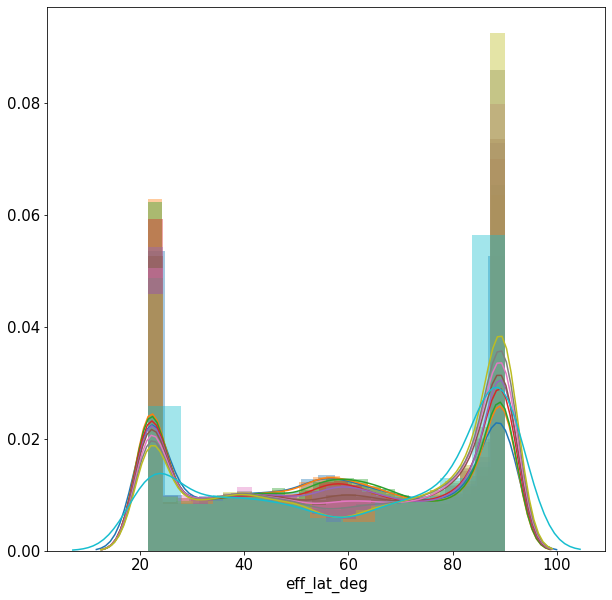

In [70]:
fig, ax = plt.subplots(figsize=(10, 10))
for decade in eff_lat.decade.unique():
    df_dec = eff_lat[eff_lat.decade == decade]
    sns.distplot(df_dec['eff_lat_deg'],
                 norm_hist=True,
                 ax=ax)

In [62]:
sns.distplots()

,temp_bracket,time,area_grid,cdf_eff_lat_mapping,eff_lat_deg,decade,year
0,216.987,2015-01-01,0.000000e+00,1.570796,90.000000,2010,2015
1,216.987,2015-01-02,0.000000e+00,1.570796,90.000000,2010,2015
2,216.987,2015-01-03,0.000000e+00,1.570796,90.000000,2010,2015
3,216.987,2015-01-04,0.000000e+00,1.570796,90.000000,2010,2015
4,216.987,2015-01-05,0.000000e+00,1.570796,90.000000,2010,2015
...,...,...,...,...,...,...,...
363822,308.987,2100-12-28,1.609070e+08,0.377257,21.615255,2100,2100
363823,308.987,2100-12-29,1.609070e+08,0.377257,21.615255,2100,2100
363824,308.987,2100-12-30,1.609070e+08,0.377257,21.615255,2100,2100
363825,308.987,2100-12-31,1.609070e+08,0.377257,21.615255,2100,2100


In [57]:
! ls /project2/geos39650/jet_stream/data/model_output/eff_lat/

eff_lat_gcm_2015_2100.csv  eff_lat_reanalysis_1980_2018.csv


In [11]:
total = xr.open_mfdataset(paths, 
                          combine='by_coords',
                          preprocess=preprocess)
total = total.rename({'__xarray_dataarray_variable__': 't_prime'})

In [12]:
total

<xarray.Dataset>
Dimensions:    (latitude: 75, longitude: 288, time: 7200)
Coordinates:
  * latitude   (latitude) float64 20.26 21.2 22.15 23.09 ... 88.12 89.06 90.0
  * longitude  (longitude) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time       (time) datetime64[ns] 2015-12-01 2015-12-02 ... 2095-02-28
Data variables:
    t_prime    (time, latitude, longitude) float64 dask.array<chunksize=(900, 75, 288), meta=np.ndarray>

### De-mean using the whole period

In [13]:
time_days = total.groupby('time.dayofyear').mean().compute()
total_demean = total.groupby('time.dayofyear') - time_days
total_demean.to_netcdf('/project2/geos39650/jet_stream/data/model_output/demean/demean_t_prime_cimp6_1980_2100.nc4')

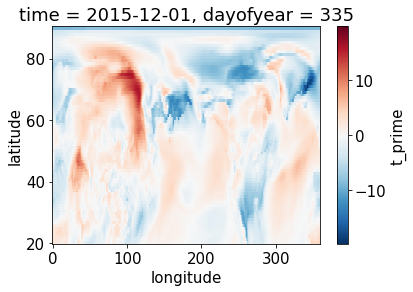

In [14]:
total_demean = xr.open_dataset('/project2/geos39650/jet_stream/data/model_output/demean/demean_t_prime_cimp6_1980_2100.nc4')
total_demean.isel(time=0).t_prime.plot()

In [17]:
t2m = xr.open_dataset('/project2/geos39650/jet_stream/cimp6_raw/IPSL-CM6A-LR_hist_tas_daily.nc4')
datetime_index = t2m.indexes['time'].to_datetimeindex()
t2m['time'] = datetime_index

AttributeError: 'DatetimeIndex' object has no attribute 'to_datetimeindex'

In [28]:
t2m.where(t2m.time.dt.season == 'DJF', drop=True)

<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, lat: 143, lon: 144, time: 14890)
Coordinates:
    height       float64 2.0
  * lat          (lat) float32 -90.0 -88.73239 -87.46479 ... 88.73239 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time         (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
    time_bounds  (time, axis_nbounds) datetime64[ns] 1850-01-01 ... 2015-01-01
Dimensions without coordinates: axis_nbounds
Data variables:
    tas          (time, lat, lon) float32 246.64886 246.64886 ... 243.83131
Attributes:
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  historical
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  124183.0
    contact:                ipsl-cmip6@listes.ipsl.fr
    creation_date:          2018-06-18T07:56:27Z
    data_specs_version:     01.00.21
    description:            CMIP6 historical
    dr2xml_md5sum:          d6225e658d7de0912fca2a4293dbe2a7
    dr2xml_version:         1.10
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacella
    forcing_index:          1
    frequency:              day
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.IPSL.IPSL-CM...
    grid:                   LMDZ grid
    grid_label:             gr
    history:                Mon Sep  3 17:43:51 2018: ncatted -O -a parent_va...
    initialization_index:   1
    institution:            Institut Pierre Simon Laplace, Paris 75252, France
    institution_id:         IPSL
    license:                CMIP6 model data produced by IPSL is licensed und...
    mip_era:                CMIP6
    model_version:          6.1.4
    name:                   /ccc/work/cont003/gencmip6/p86maf/IGCM_OUT/IPSLCM...
    nominal_resolution:     250 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       IPSL-CM6A-LR
    parent_time_units:      days since 1850-01-01 00:00:00
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      10
    realm:                  atmos
    source:                 IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; 144...
    source_id:              IPSL-CM6A-LR
    source_type:            AOGCM BGC
    status:                 2020-01-13;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               day
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / CM...
    tracking_id:            hdl:21.14100/f4741102-d463-4777-a1f9-82adce092c22
    variable_id:            tas
    variant_label:          r10i1p1f1

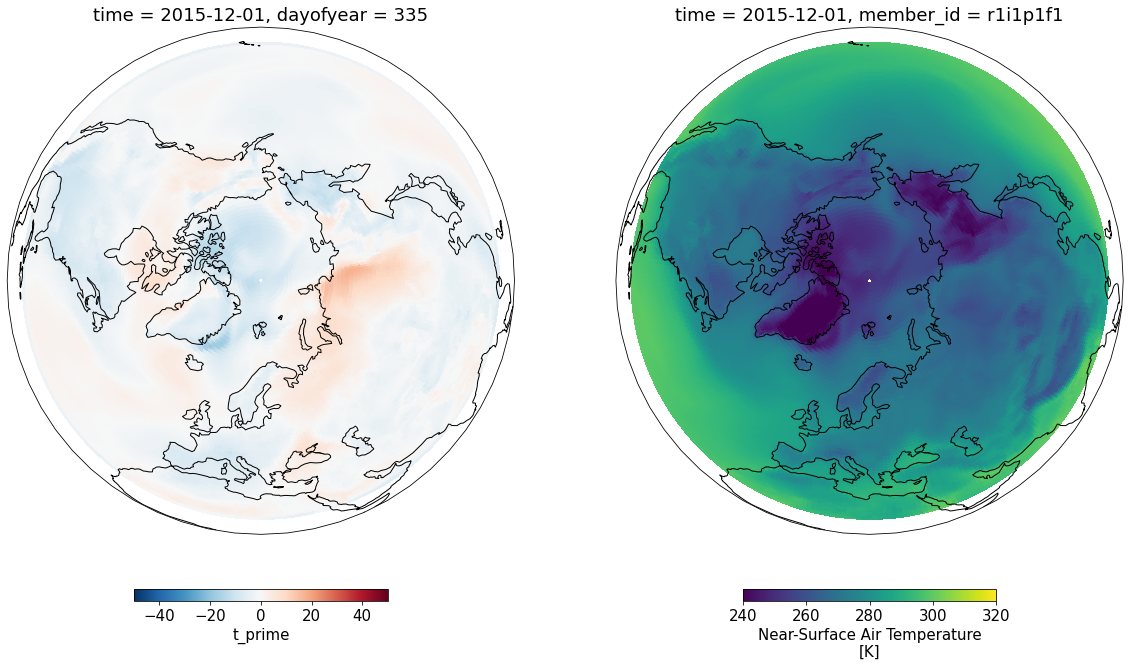

In [18]:
fig_ = plt.figure(figsize=(20, 20))
ax_1 = fig_.add_subplot(121, projection=ccrs.Orthographic(20, 90))
ax_2 = fig_.add_subplot(122, projection=ccrs.Orthographic(20, 90))

total_demean.isel(time=0).t_prime.plot.pcolormesh(ax=ax_1,
                                      cmap='RdBu_r',
                                      vmax=-50,
                                      vmin=50,
                                      center=0,
                                      transform=ccrs.PlateCarree(),
                                      extend='neither',
                                      cbar_kwargs={'orientation': 'horizontal',
                                                  'pad': 0.05,
                                                  'shrink': 0.5,
                                                  'spacing': 'proportional'
                                                 }
                         )

t2m.isel(time=59, member_id=0).tas.plot.pcolormesh(ax=ax_2,
                                      #cmap='RdBu_r',
                                      vmin=240,
                                      vmax=320,
                                      #center=0,
                                      transform=ccrs.PlateCarree(),
                                      extend='neither',
                                      cbar_kwargs={'orientation': 'horizontal',
                                                  'pad': 0.05,
                                                  'shrink': 0.5,
                                                  'spacing': 'proportional'
                                                 }
                         )

ax_1.set_global()
ax_1.coastlines()
ax_2.set_global()
ax_2.coastlines()

### Joyplot

In [30]:
import joypy

#total_demean_resample = total_demean.resample(time='3M').mean().compute()
total_demean_resample_chi = total_demean.sel({'longitude': 272.5, 'latitude':42.879581},  method='nearest')

In [31]:
total_demean_resample_chi

<xarray.Dataset>
Dimensions:    (time: 7200)
Coordinates:
    latitude   float64 42.88
    longitude  float64 272.5
  * time       (time) datetime64[ns] 2015-12-01 2015-12-02 ... 2095-02-28
    dayofyear  (time) int64 ...
Data variables:
    t_prime    (time) float64 ...

In [39]:
df_decade_model = total_demean_resample_chi.to_dataframe()
#df_decade_model.reset_index(drop=False, inplace=True)

In [35]:
df_decade_model['decade'] = df_decade_model.time.dt.year.apply(lambda x: int(x)//10 * 10)
df_decade_model['year'] = df_decade_model.time.dt.year
df_decade_model

,time,latitude,longitude,dayofyear,t_prime,decade,year
0,2015-12-01,42.879581,272.5,335,-0.622006,2010,2015
1,2015-12-02,42.879581,272.5,336,-1.831302,2010,2015
2,2015-12-03,42.879581,272.5,337,-2.542369,2010,2015
3,2015-12-04,42.879581,272.5,338,-1.677618,2010,2015
4,2015-12-05,42.879581,272.5,339,-1.404306,2010,2015
...,...,...,...,...,...,...,...
7195,2095-02-24,42.879581,272.5,55,1.625000,2090,2095
7196,2095-02-25,42.879581,272.5,56,5.938239,2090,2095
7197,2095-02-26,42.879581,272.5,57,10.152881,2090,2095
7198,2095-02-27,42.879581,272.5,58,6.159152,2090,2095


In [40]:
def group_into_winters(dates): #untested
    year_arr = np.zeros(len(dates),dtype=int)
    y=0
    for date in dates:
        if date.month < 3:
            year_arr[y] = date.year - 1
        else:
            year_arr[y] = date.year
        y+=1
    return year_arr

def joy_div(data,
            time_key='year',
            data_key='t_prime',
            decade=False):
    ''' accepts a dataframe and make a joy division plot of successive distributions in data_key. 
     If decade=False, these distributions are calculated yearly. If True, they are calculated every 10 years'''
            
    data['year'] = group_into_winters(data.index)
    time_key='year'
    if decade:
        time_key='decade'
        data['decade'] = data.year.apply(lambda x: int(x)//10 * 10)
    data_filter = data.filter([time_key, data_key])
    
    labels=[y if y%5==0 else None for y in list(data[time_key].unique())]
    fig, axes = joypy.joyplot(data_filter, 
                          by=time_key,
                              labels=labels,
                              grid='y',
                              linewidth=1,
                          column=data_key,
                          fade=True,
                          figsize=(10, 10))
    plt.xlabel("T' [K]")
    plt.ylabel("year")
    plt.show()
    plt.savefig('/home/ivanhigueram/public_html/joy_plt_prj.png')
    return data_filter

In [41]:
df_decade_model

,latitude,longitude,dayofyear,t_prime
time,,,,
2015-12-01,42.879581,272.5,335,-0.622006
2015-12-02,42.879581,272.5,336,-1.831302
2015-12-03,42.879581,272.5,337,-2.542369
2015-12-04,42.879581,272.5,338,-1.677618
2015-12-05,42.879581,272.5,339,-1.404306
...,...,...,...,...
2095-02-24,42.879581,272.5,55,1.625000
2095-02-25,42.879581,272.5,56,5.938239
2095-02-26,42.879581,272.5,57,10.152881


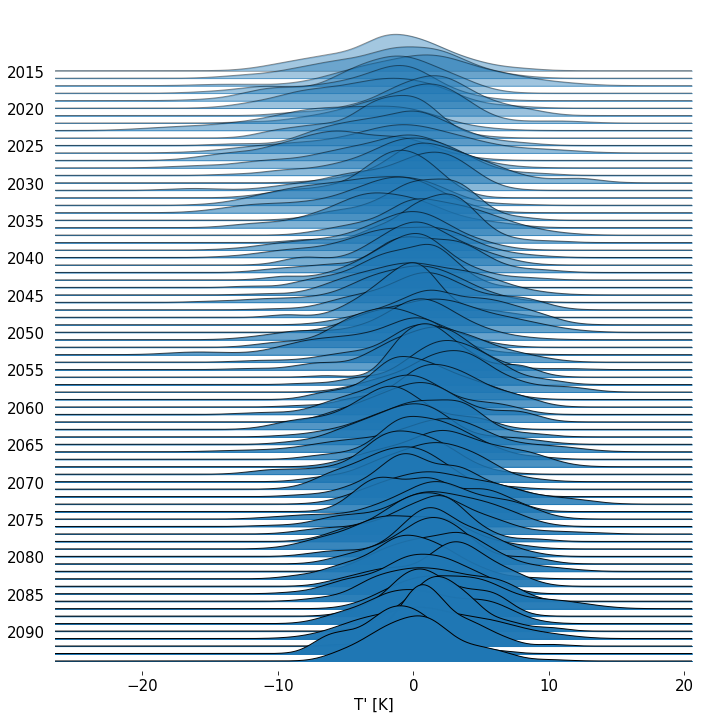

,year,t_prime
time,,
2015-12-01,2015,-0.622006
2015-12-02,2015,-1.831302
2015-12-03,2015,-2.542369
2015-12-04,2015,-1.677618
2015-12-05,2015,-1.404306
...,...,...
2095-02-24,2094,1.625000
2095-02-25,2094,5.938239
2095-02-26,2094,10.152881


<Figure size 432x288 with 0 Axes>

In [42]:
joy_div(df_decade_model)

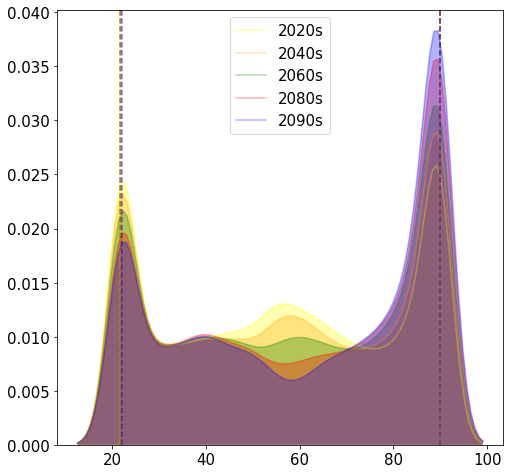

In [79]:
fig, ax = plt.subplots(figsize=(8, 8))
overlayed_decades(eff_lat,2020,clr='yellow', ax=ax, var='eff_lat_deg')
overlayed_decades(eff_lat,2040,clr='orange', ax=ax, var='eff_lat_deg')
overlayed_decades(eff_lat,2060,clr='green', ax=ax, var='eff_lat_deg')
overlayed_decades(eff_lat,2080,clr='red', ax=ax, var='eff_lat_deg')
overlayed_decades(eff_lat,2090,clr='blue', ax=ax, var='eff_lat_deg')

In [76]:
def overlayed_decades(data,
                      year,
                      ax,
                      var='t_prime',
                      clr='blue'):
    data_in_decade = data.loc[(data['decade']==year),var]
    
    sns.kdeplot(data_in_decade, 
                ax=ax,
                shade=True, 
                alpha=0.3, 
                Label=str(year)+'s',
                color=clr)
    
    quantiles = np.quantile(data_in_decade,[0.1,0.9])
    
    plt.axvline(quantiles[0],color=clr,linestyle='--',alpha=0.5)
    plt.axvline(quantiles[1],color=clr,linestyle='--',alpha=0.5)

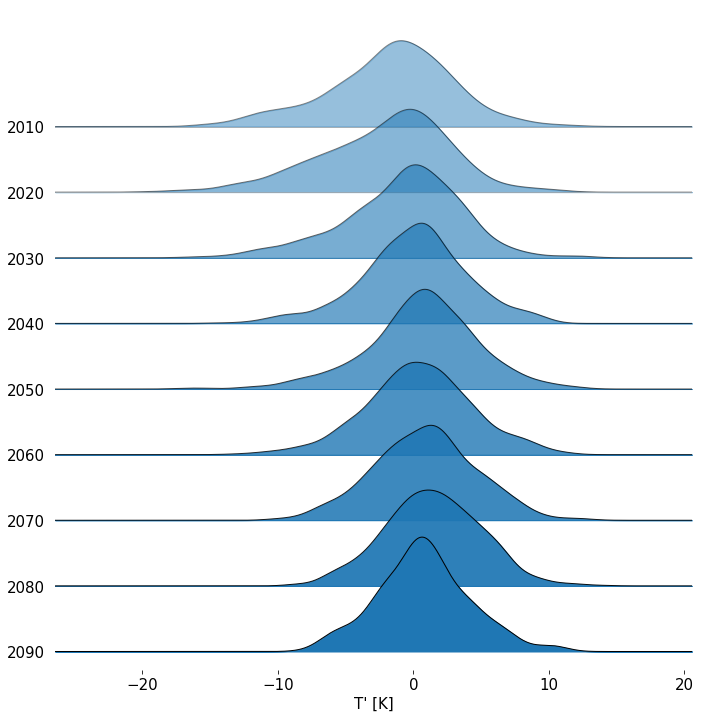

<Figure size 432x288 with 0 Axes>

In [44]:
decadal_data = joy_div(df_decade_model, 
                       decade=True)

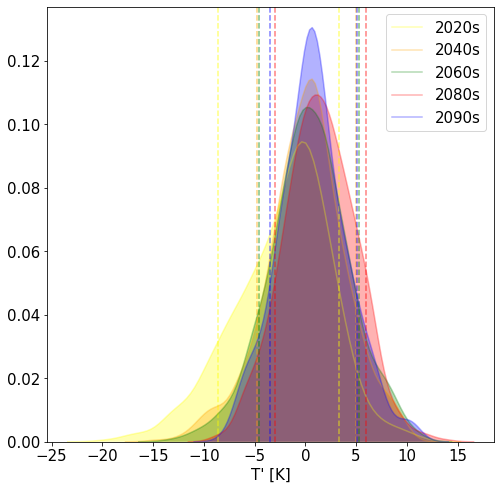

In [45]:
fig, ax = plt.subplots(figsize=(8, 8))
overlayed_decades(decadal_data,2020,clr='yellow', ax=ax)
overlayed_decades(decadal_data,2040,clr='orange', ax=ax)
overlayed_decades(decadal_data,2060,clr='green', ax=ax)
overlayed_decades(decadal_data,2080,clr='red', ax=ax)
overlayed_decades(decadal_data,2090,clr='blue', ax=ax)
plt.xlabel("T' [K]")
plt.show()

### Hovmuller

In [71]:
def hovmoller(data,lat_range):
    data_strip = data.sel({'latitude': lat_range, 'time':selected_dates})
    meaned_data_strip = data_strip.mean(dim=['latitude']).reset_coords('dayofyear',drop=True)
    meaned_data_strip.to_array().plot()
    plt.title(r"$T'$ at Latitude $\sim 40 ^\circ$ in Winter 2016")

### Loop over years to create a movie

In [ ]:
def plot_avg(data, ax, **kwargs):
    
    # Add layers to axis
    ax.set_global()
    ax.coastlines()
    
    # Plotting function
    data.plot.pcolormesh(ax = ax, 
                         transform=ccrs.PlateCarree(),
                         vmin =params['min'], 
                         vmax=params['max'] ,
                         cmap=params['colormap'], 
                         cbar_kwargs={'orientation': 'horizontal',
                                      'pad': 0.05,
                                      'shrink': 0.5,
                                      'spacing': 'proportional'
                                     }
                        )

In [130]:
for day in range(2800, 2950):    
    rat = (day - 2800)/(2950-2800) * (150 - 1) + 1
    print(int(np.ceil(rat)))
    
    fig = plt.subplots(figsize=(10, 10))

    total_demean.t_prime.isel(time=day).plot.pcolormesh(ax=ax,
                                          cmap='RdBu_r',
                                          vmax=40,
                                          vmin=-40,
                                          center=0.0,
                                          transform=ccrs.PlateCarree(),
                                          extend='neither',
                                          cbar_kwargs={'orientation': 'horizontal',
                                                      'pad': 0.05,
                                                      'shrink': 0.5,
                                                      'spacing': 'proportional'
                                                     }
                             )
    plt.tight_layout()
    ax.set_global()
    ax.coastlines()
    plt.savefig(f'{os.getenv("SCRATCH")}/figs/t_prime_decades_polar_div_{str(int(rat)).zfill(3)}.png')
    plt.clf()

1


/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

### Loop over year with t2m side by side

In [38]:
top_range = 3400
ceil_range = 3200
for day in range(ceil_range, top_range): 
    rat = (day - ceil_range)/(top_range-ceil_range) * ((top_range-ceil_range) - 1) + 1
    print(int(np.ceil(rat)))


    fig_ = plt.figure(figsize=(20, 20))
    ax_1 = fig_.add_subplot(121, projection=ccrs.Orthographic(20, 90))
    ax_2 = fig_.add_subplot(122, projection=ccrs.Orthographic(20, 90))

    total_demean.isel(time=day).t_prime.plot.pcolormesh(ax=ax_1,
                                          cmap='RdBu_r',
                                          vmax=-50,
                                          vmin=50,
                                          center=0,
                                          transform=ccrs.PlateCarree(),
                                          extend='neither',
                                          cbar_kwargs={'orientation': 'horizontal',
                                                      'pad': 0.05,
                                                      'shrink': 0.5,
                                                      'spacing': 'proportional'
                                                     }
                             )

    t2m.isel(time=day).t2m.plot.pcolormesh(ax=ax_2,
                                          #cmap='RdBu_r',
                                          vmin=240,
                                          vmax=320,
                                          #center=0,
                                          transform=ccrs.PlateCarree(),
                                          extend='neither',
                                          cbar_kwargs={'orientation': 'horizontal',
                                                      'pad': 0.05,
                                                      'shrink': 0.5,
                                                      'spacing': 'proportional'
                                                     }
                             )

    ax_1.set_global()
    ax_1.coastlines()
    ax_2.set_global()
    ax_2.coastlines()

    plt.savefig(f'{os.getenv("SCRATCH")}/t2m_plots/t2m_t_prime_decades_polar_div_{str(int(rat)).zfill(3)}.png')
    plt.clf()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [82]:
test_tref = xr.open_dataset('../t_ref_gcm_2095-12-01_2105-03-01.nc4')

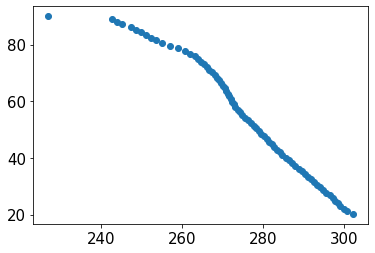

In [83]:
plt.scatter(x=test_tref.isel(time=1, longitude=10).__xarray_dataarray_variable__.data, y=test_tref.latitude)

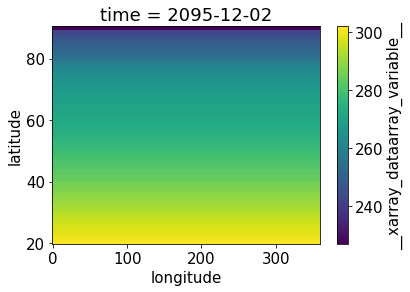

In [84]:
test_tref.__xarray_dataarray_variable__.isel(time=1).plot()